In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def lightcurvedata(file):
    time,magA,magA_err,magB,magB_err = \
    np.loadtxt(file,skiprows=2,usecols=(0,1,2,3,4),unpack=True)
    return time,magA,magA_err,magB,magB_err

R_mag = lightcurvedata('lightcurves_he2149R.txt')
V_mag = lightcurvedata('lightcurves_he2149V.txt')

In [3]:
timedelay = -32.4/365.25

In [4]:
def plot(mag,offsetA=0.0,offsetB=0.0,lable1='',lable2='',sym1='o',sym2='o',timedelay=timedelay,alpha=1.0):
    plt.errorbar(mag[0],mag[1]+offsetA,yerr=mag[2],fmt=sym1,alpha=alpha,markersize=4,elinewidth=1,capsize=3,label=lable1)
    plt.errorbar(mag[0]+timedelay,mag[3]+offsetB,yerr=mag[4],fmt=sym2,alpha=alpha,markersize=4,elinewidth=1,capsize=3,label=lable2)

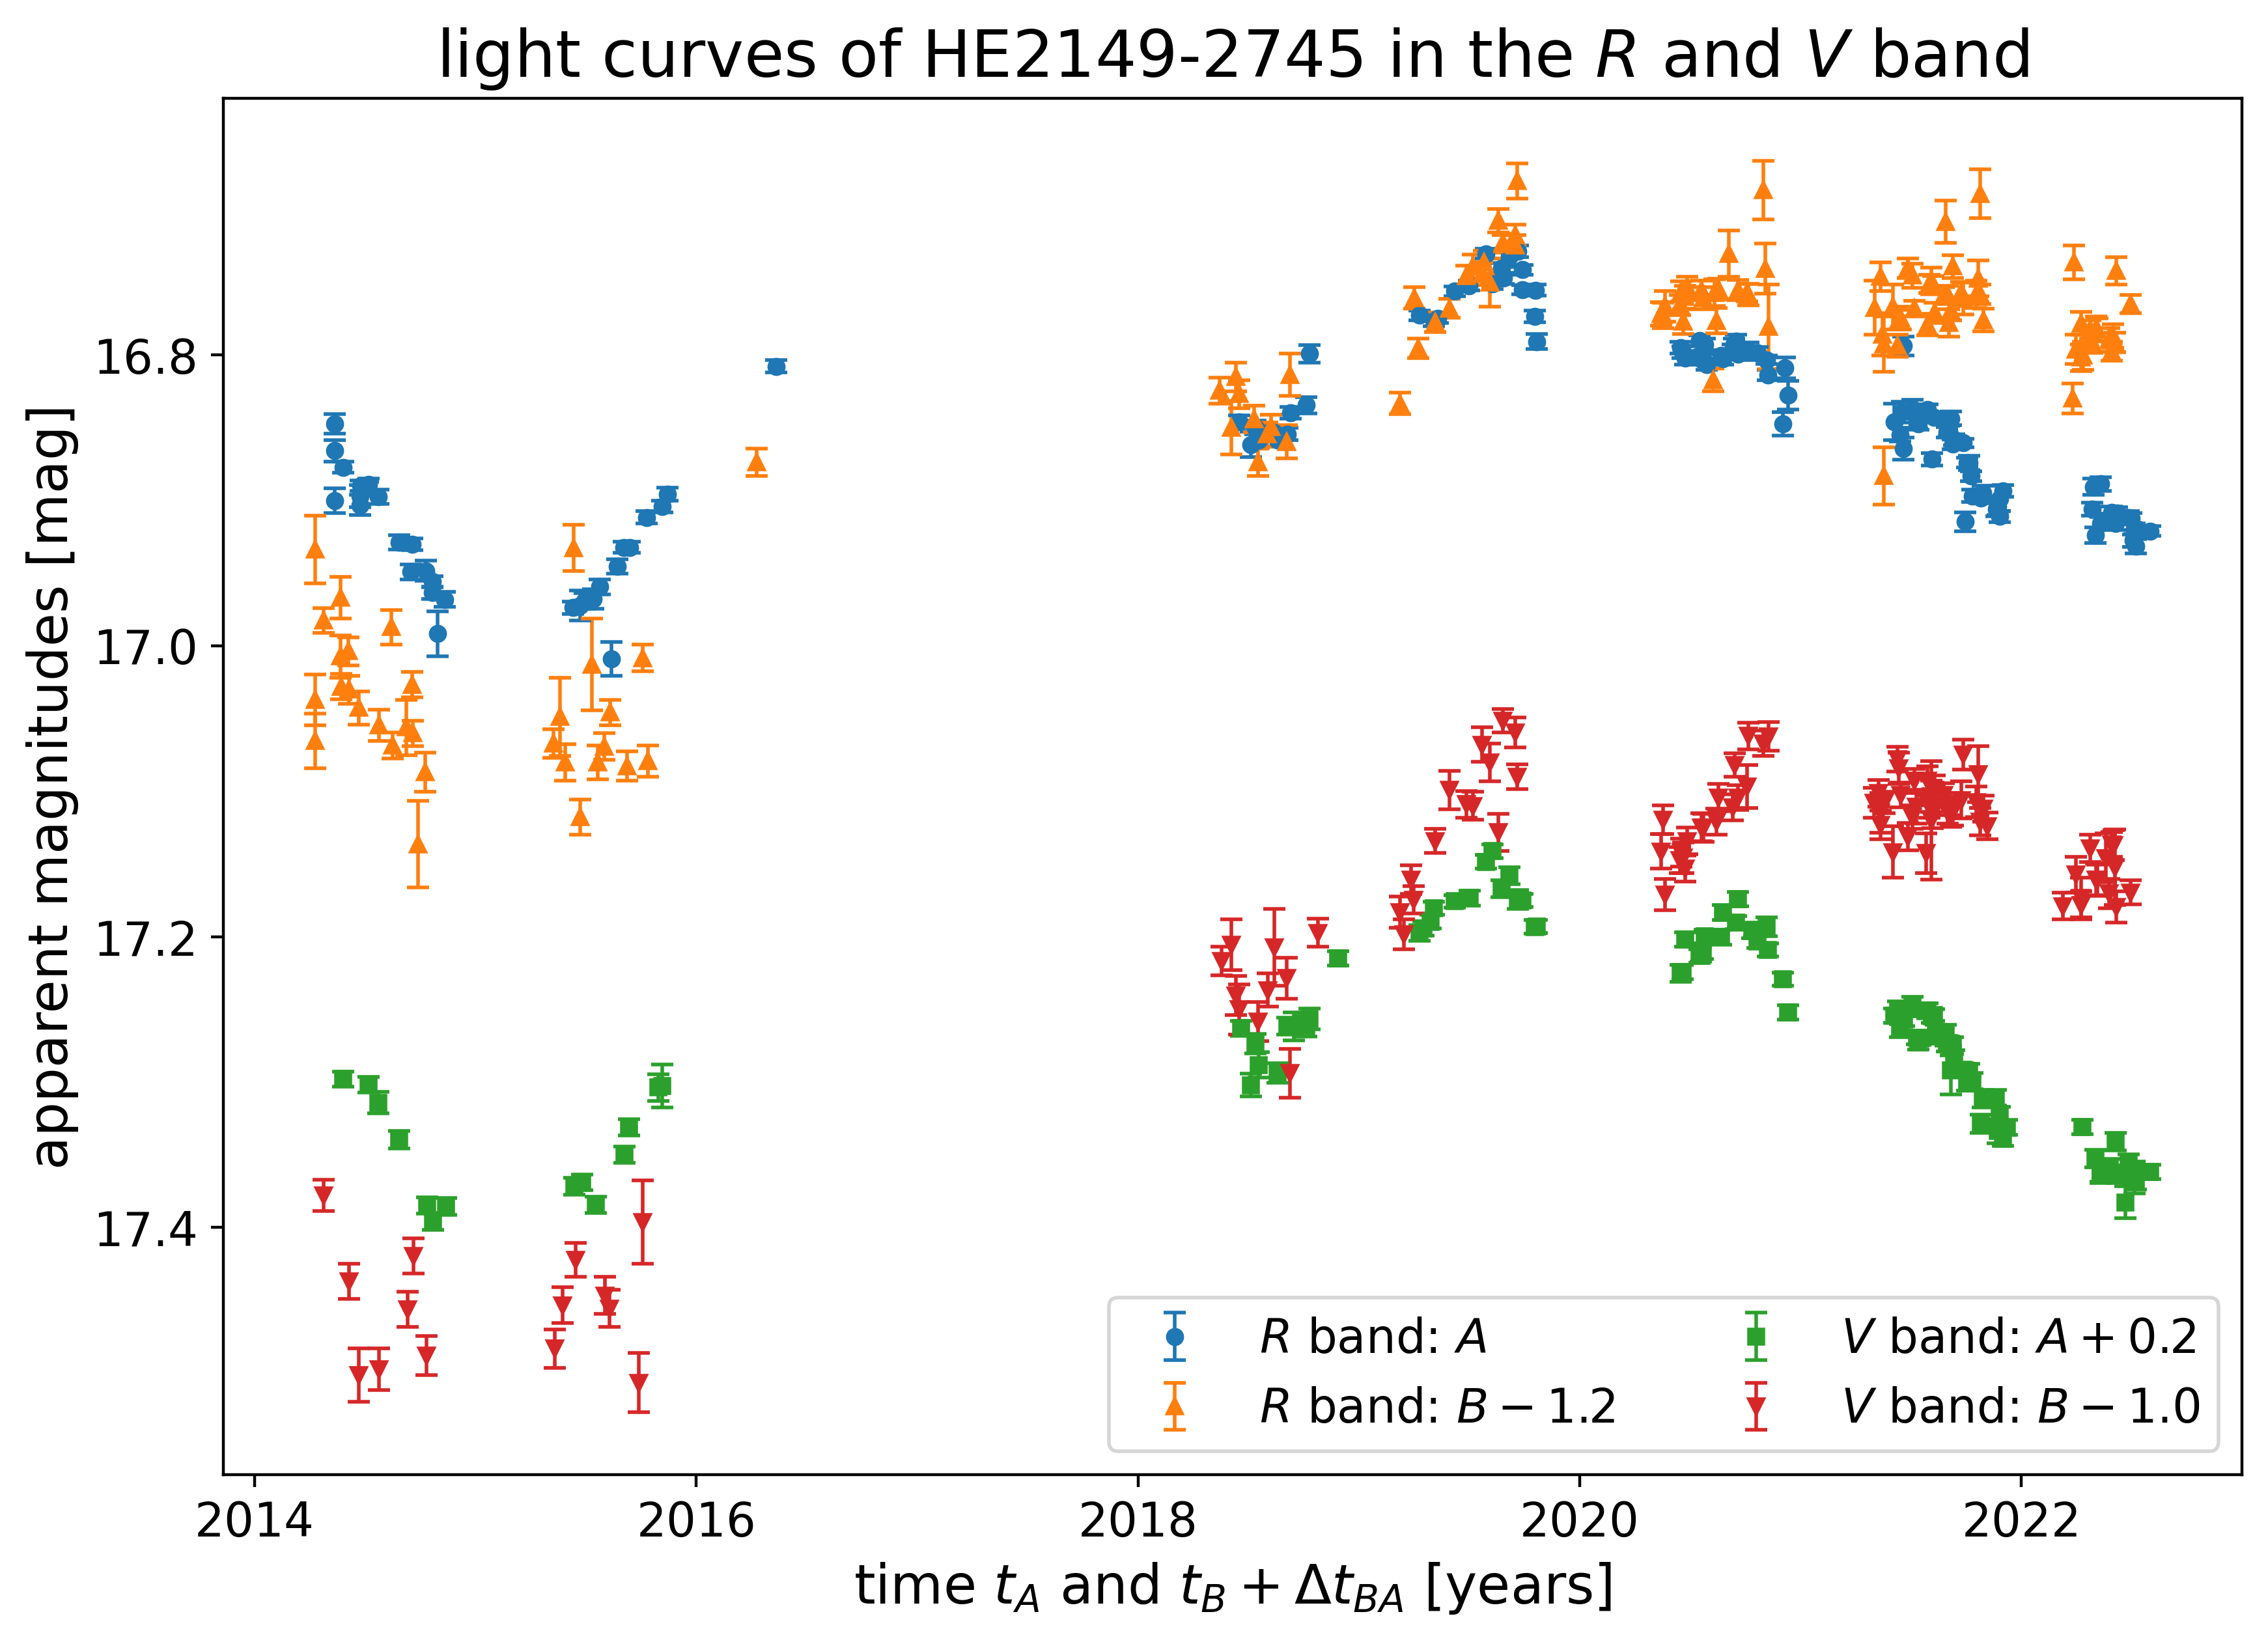

In [5]:
plt.figure(figsize=(10,7),dpi=400)
plt.title('light curves of HE2149-2745 in the $R$ and $V$ band',size=18)
plot(R_mag,0.0,-1.2,'$R$ band: $A$','$R$ band: $B-1.2$','o','^',timedelay)
plot(V_mag,0.2,-1.0,'$V$ band: $A+0.2$','$V$ band: $B-1.0$','s','v',timedelay)
plt.gca().invert_yaxis()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('time $t_A$ and $t_B+\Delta t_{BA}$ [years]',size=15)
plt.ylabel('apparent magnitudes [mag]',size=15)
plt.legend(fontsize=13,ncol=2)

In [42]:
def interpcurveA(mag,timedelay=timedelay,maxtimegap=50):
    
    timesortedindicees = np.argsort(mag[0])
    
    timeA = mag[0][timesortedindicees]
    magA  = mag[1][timesortedindicees]
    errA  = mag[2][timesortedindicees]
    timeB = mag[0][timesortedindicees]+timedelay
    magB  = mag[3][timesortedindicees]
    errB  = mag[4][timesortedindicees]
    
    time_mask = np.where((timeB > np.min(timeA)) & (timeB < np.max(timeA)))
    time = timeB[time_mask]
    
    ################################
    # I SHOULDNT BE DOING THAT !!! #
    time = np.unique(np.round(time*365.25)/365.25) # rounding to whole day and only using that day once
    # I SHOULDNT BE DOING THAT !!! #
    ################################
    
    #print(np.array(np.diff(timeA)<maxtimegap/365.25)) # check timeA differences! too long gaps --> False
    #print(np.searchsorted(timeA,time)-1) # in which gap would data point of time that would be used fall in timeA?
    #print(np.array(np.diff(timeA)<maxtimegap/365.25)[np.searchsorted(timeA,time)-1])
    time = time[np.array(np.diff(timeA)<maxtimegap/365.25)[np.searchsorted(timeA,time)-1]]
    time_mask = np.argsort(timeB)[np.searchsorted(timeB,time)]
    #print(time,time_mask,np.array_equal(timeB[time_mask],time))
    #print(len(time),len(np.unique(time)))
    
    fA = interpolate.interp1d(timeA,magA,kind='linear')
    magA_interp = fA(time)
    
    N = 2048
    mc_magA = np.zeros((len(timeA),N))
    for i in range(len(timeA)):
        mc_magA[i] = np.random.normal(magA[i],errA[i],N)
    mc_magA = np.swapaxes(mc_magA,0,1)
    mc_magA_interp = np.zeros((N,len(time)))
    for j in range(N):
        fAmc = interpolate.interp1d(timeA,mc_magA[j],kind='linear')
        mc_magA_interp[j] = fAmc(time)
    errA_interp = np.std(mc_magA_interp,axis=0)
    magA_test = 1000*np.max(np.abs(np.mean(mc_magA_interp,axis=0)-magA_interp))
    if magA_test > 1.0:
        print('WARNING: maximum MC vs. interp. data point deviation:',magA_test,'mmag')
    
    # what about extrapolating a little bit?

    return time,magA_interp,errA_interp,magB[time_mask],errB[time_mask]

R_mag_interp = interpcurveA(R_mag,maxtimegap=20)
V_mag_interp = interpcurveA(V_mag,maxtimegap=20)

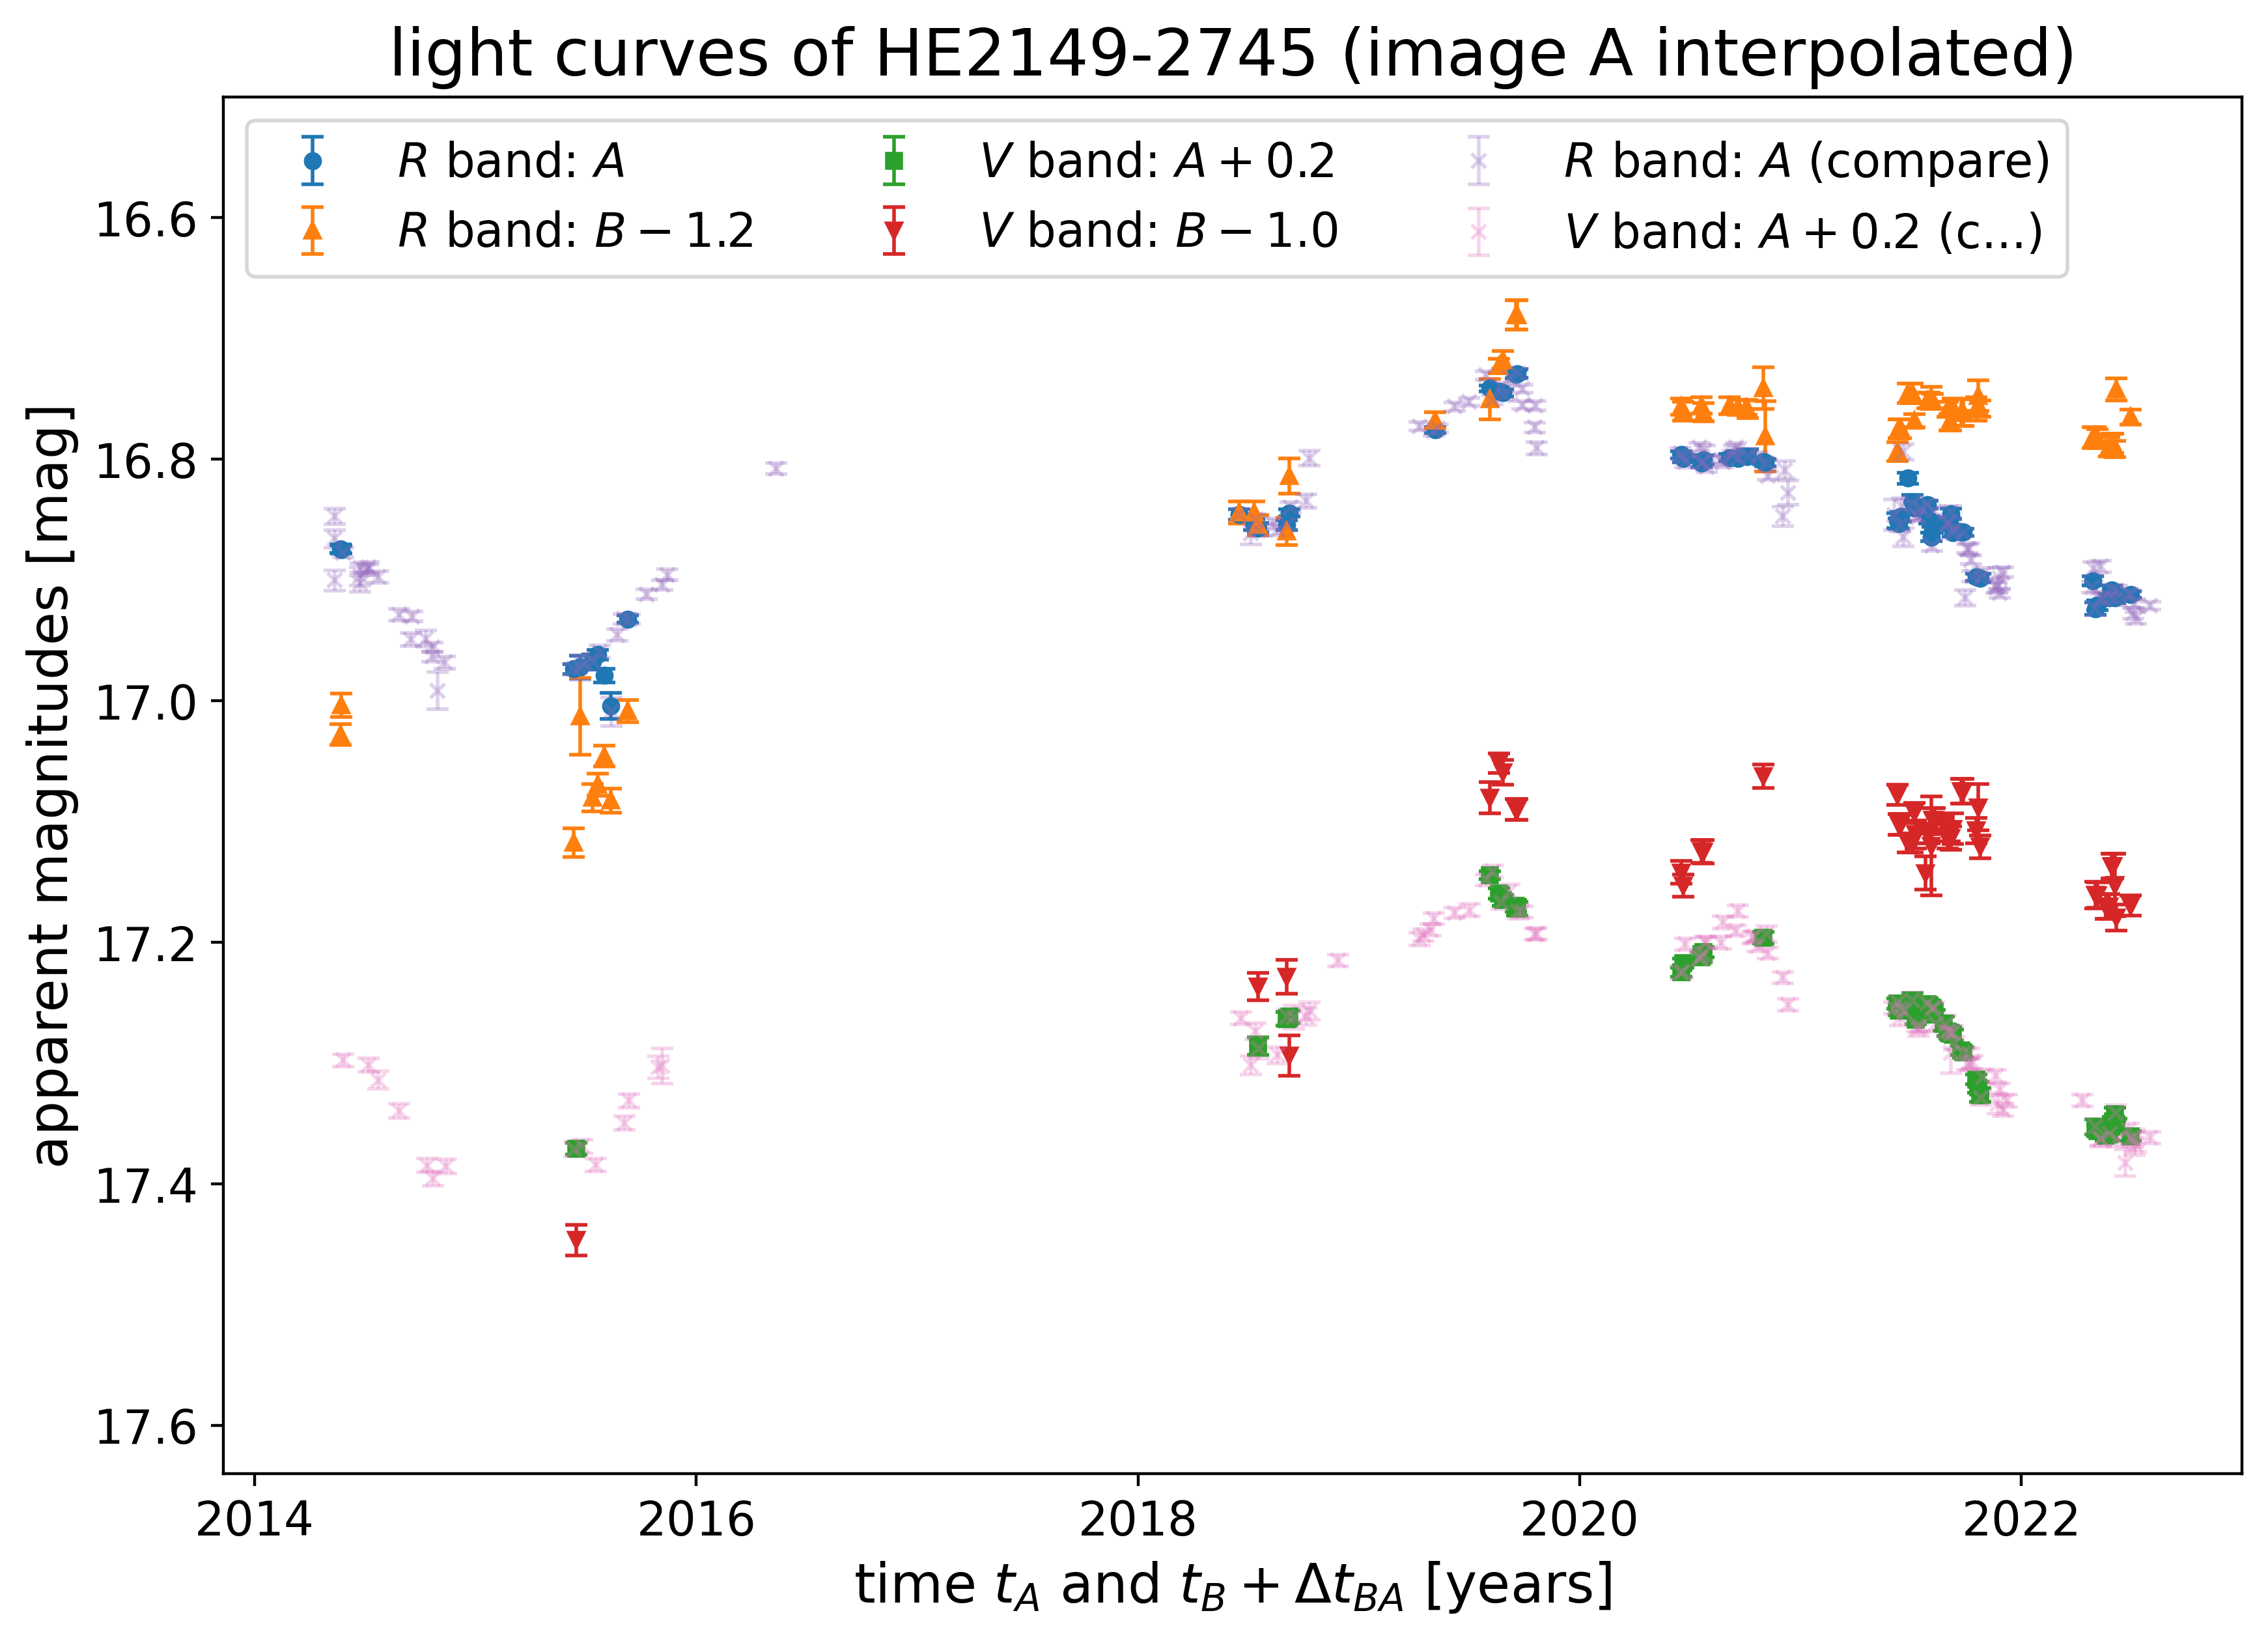

In [43]:
plt.figure(figsize=(10,7),dpi=400)
plt.title('light curves of HE2149-2745 (image A interpolated)',size=18)
plot(R_mag_interp,0.0,-1.2,'$R$ band: $A$','$R$ band: $B-1.2$','o','^',0.0)
plot(V_mag_interp,0.2,-1.0,'$V$ band: $A+0.2$','$V$ band: $B-1.0$','s','v',0.0)
plot(R_mag,0.0,10.0,'$R$ band: $A$ (compare)','','x','x',timedelay,0.3)
plot(V_mag,0.2,10.0,'$V$ band: $A+0.2$ (c...)','','x','x',timedelay,0.3)
plt.ylim([16.5,17.64]) # just to make enough space for the legend
plt.gca().invert_yaxis()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('time $t_A$ and $t_B+\Delta t_{BA}$ [years]',size=15)
plt.ylabel('apparent magnitudes [mag]',size=15)
plt.legend(fontsize=13,loc='upper left',ncol=3)

In [44]:
def diffcurve(mag):
    time = mag[0]
    magA = mag[1]
    errA = mag[2]
    magB = mag[3]
    errB = mag[4]
    
    diff = magA - magB
    derr = np.sqrt(errA**2+errB**2)
    
    return time,diff,derr

R_diff = diffcurve(R_mag_interp)
V_diff = diffcurve(V_mag_interp)

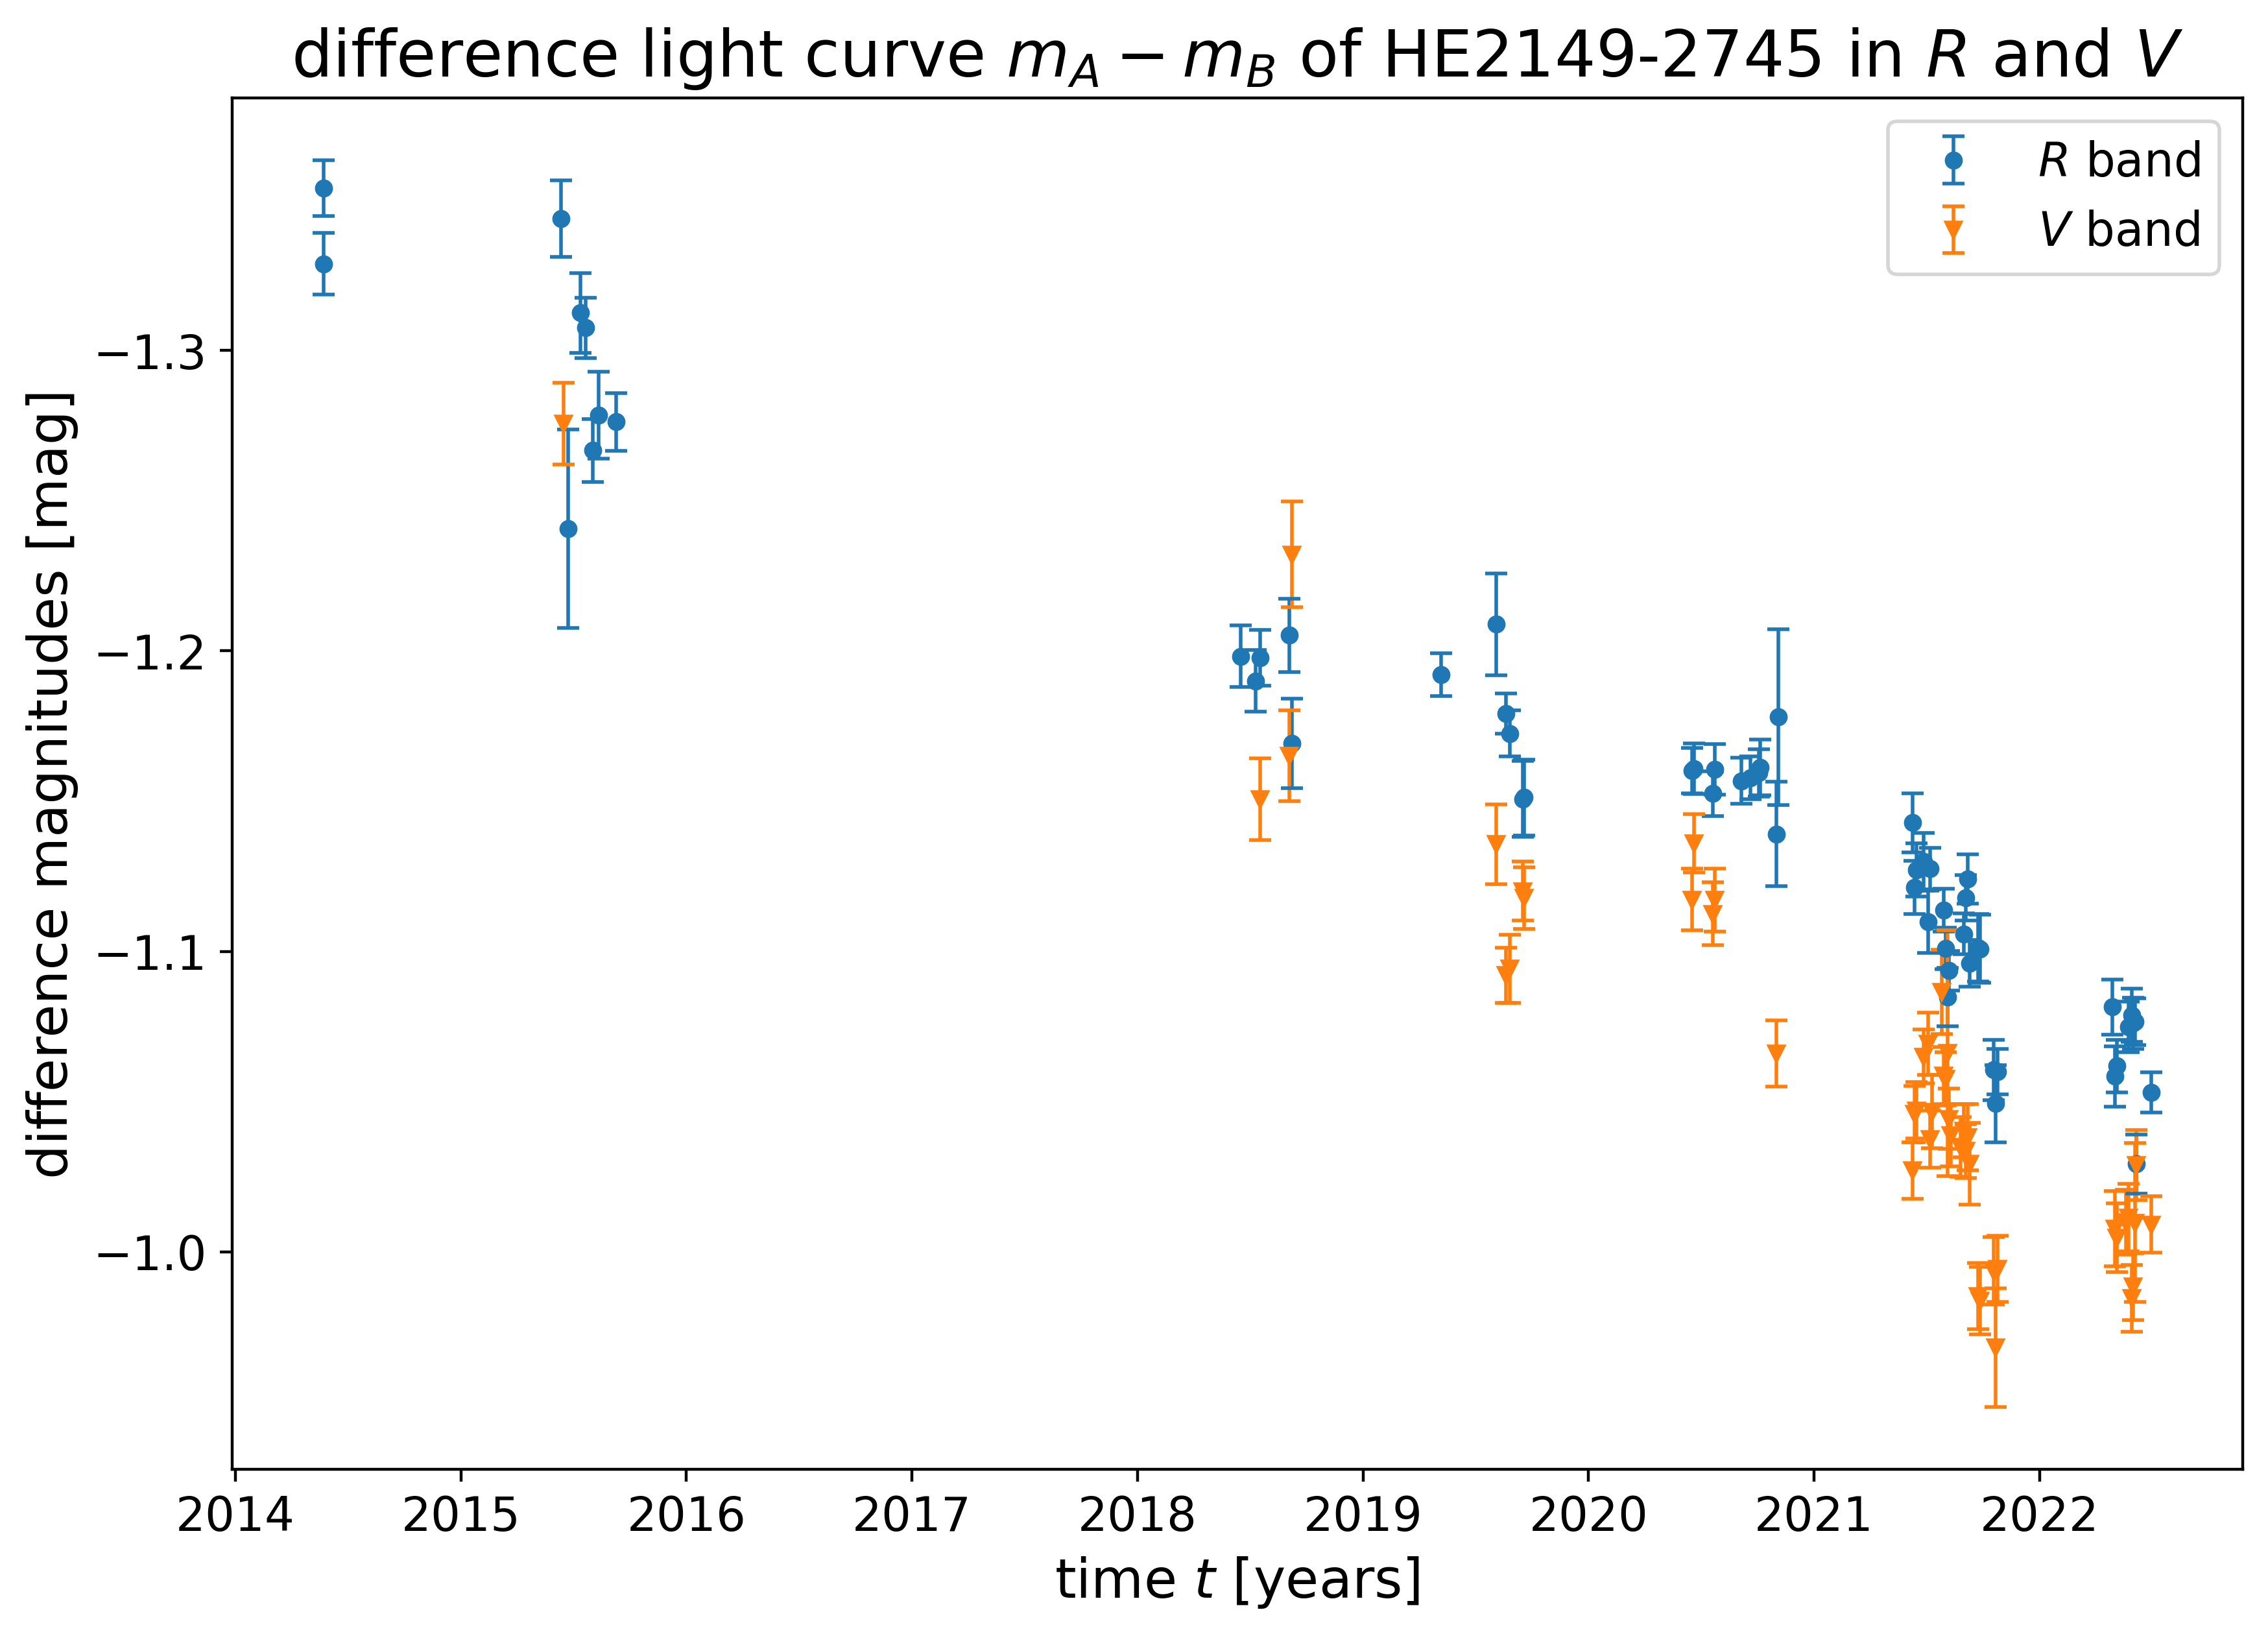

In [45]:
plt.figure(figsize=(10,7),dpi=400)
plt.title('difference light curve $m_A-m_B$ of HE2149-2745 in $R$ and $V$',size=18)
plt.errorbar(R_diff[0],R_diff[1],yerr=R_diff[2],fmt='o',markersize=4,elinewidth=1,capsize=3,label='$R$ band')
plt.errorbar(V_diff[0],V_diff[1],yerr=V_diff[2],fmt='v',markersize=4,elinewidth=1,capsize=3,label='$V$ band')
plt.gca().invert_yaxis()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('time $t$ [years]',size=15)
plt.ylabel('difference magnitudes [mag]',size=15)
plt.legend(fontsize=13)

In [46]:
eqdateR = np.in1d(R_diff[0],V_diff[0])
eqdateV = np.in1d(V_diff[0],R_diff[0])
eq_time = R_diff[0][eqdateR]
RV_diff = R_diff[1][eqdateR] - V_diff[1][eqdateV]
RV_derr = np.sqrt(R_diff[2][eqdateR]**2 + V_diff[2][eqdateV]**2)
len(eq_time)
# MIST: Jetzt sind sie natürlich nie gleichzeitig...
# ALSO: Doch auf Datum oder ähnliches Runden...
# ODER: Wieder interpolieren!?

40

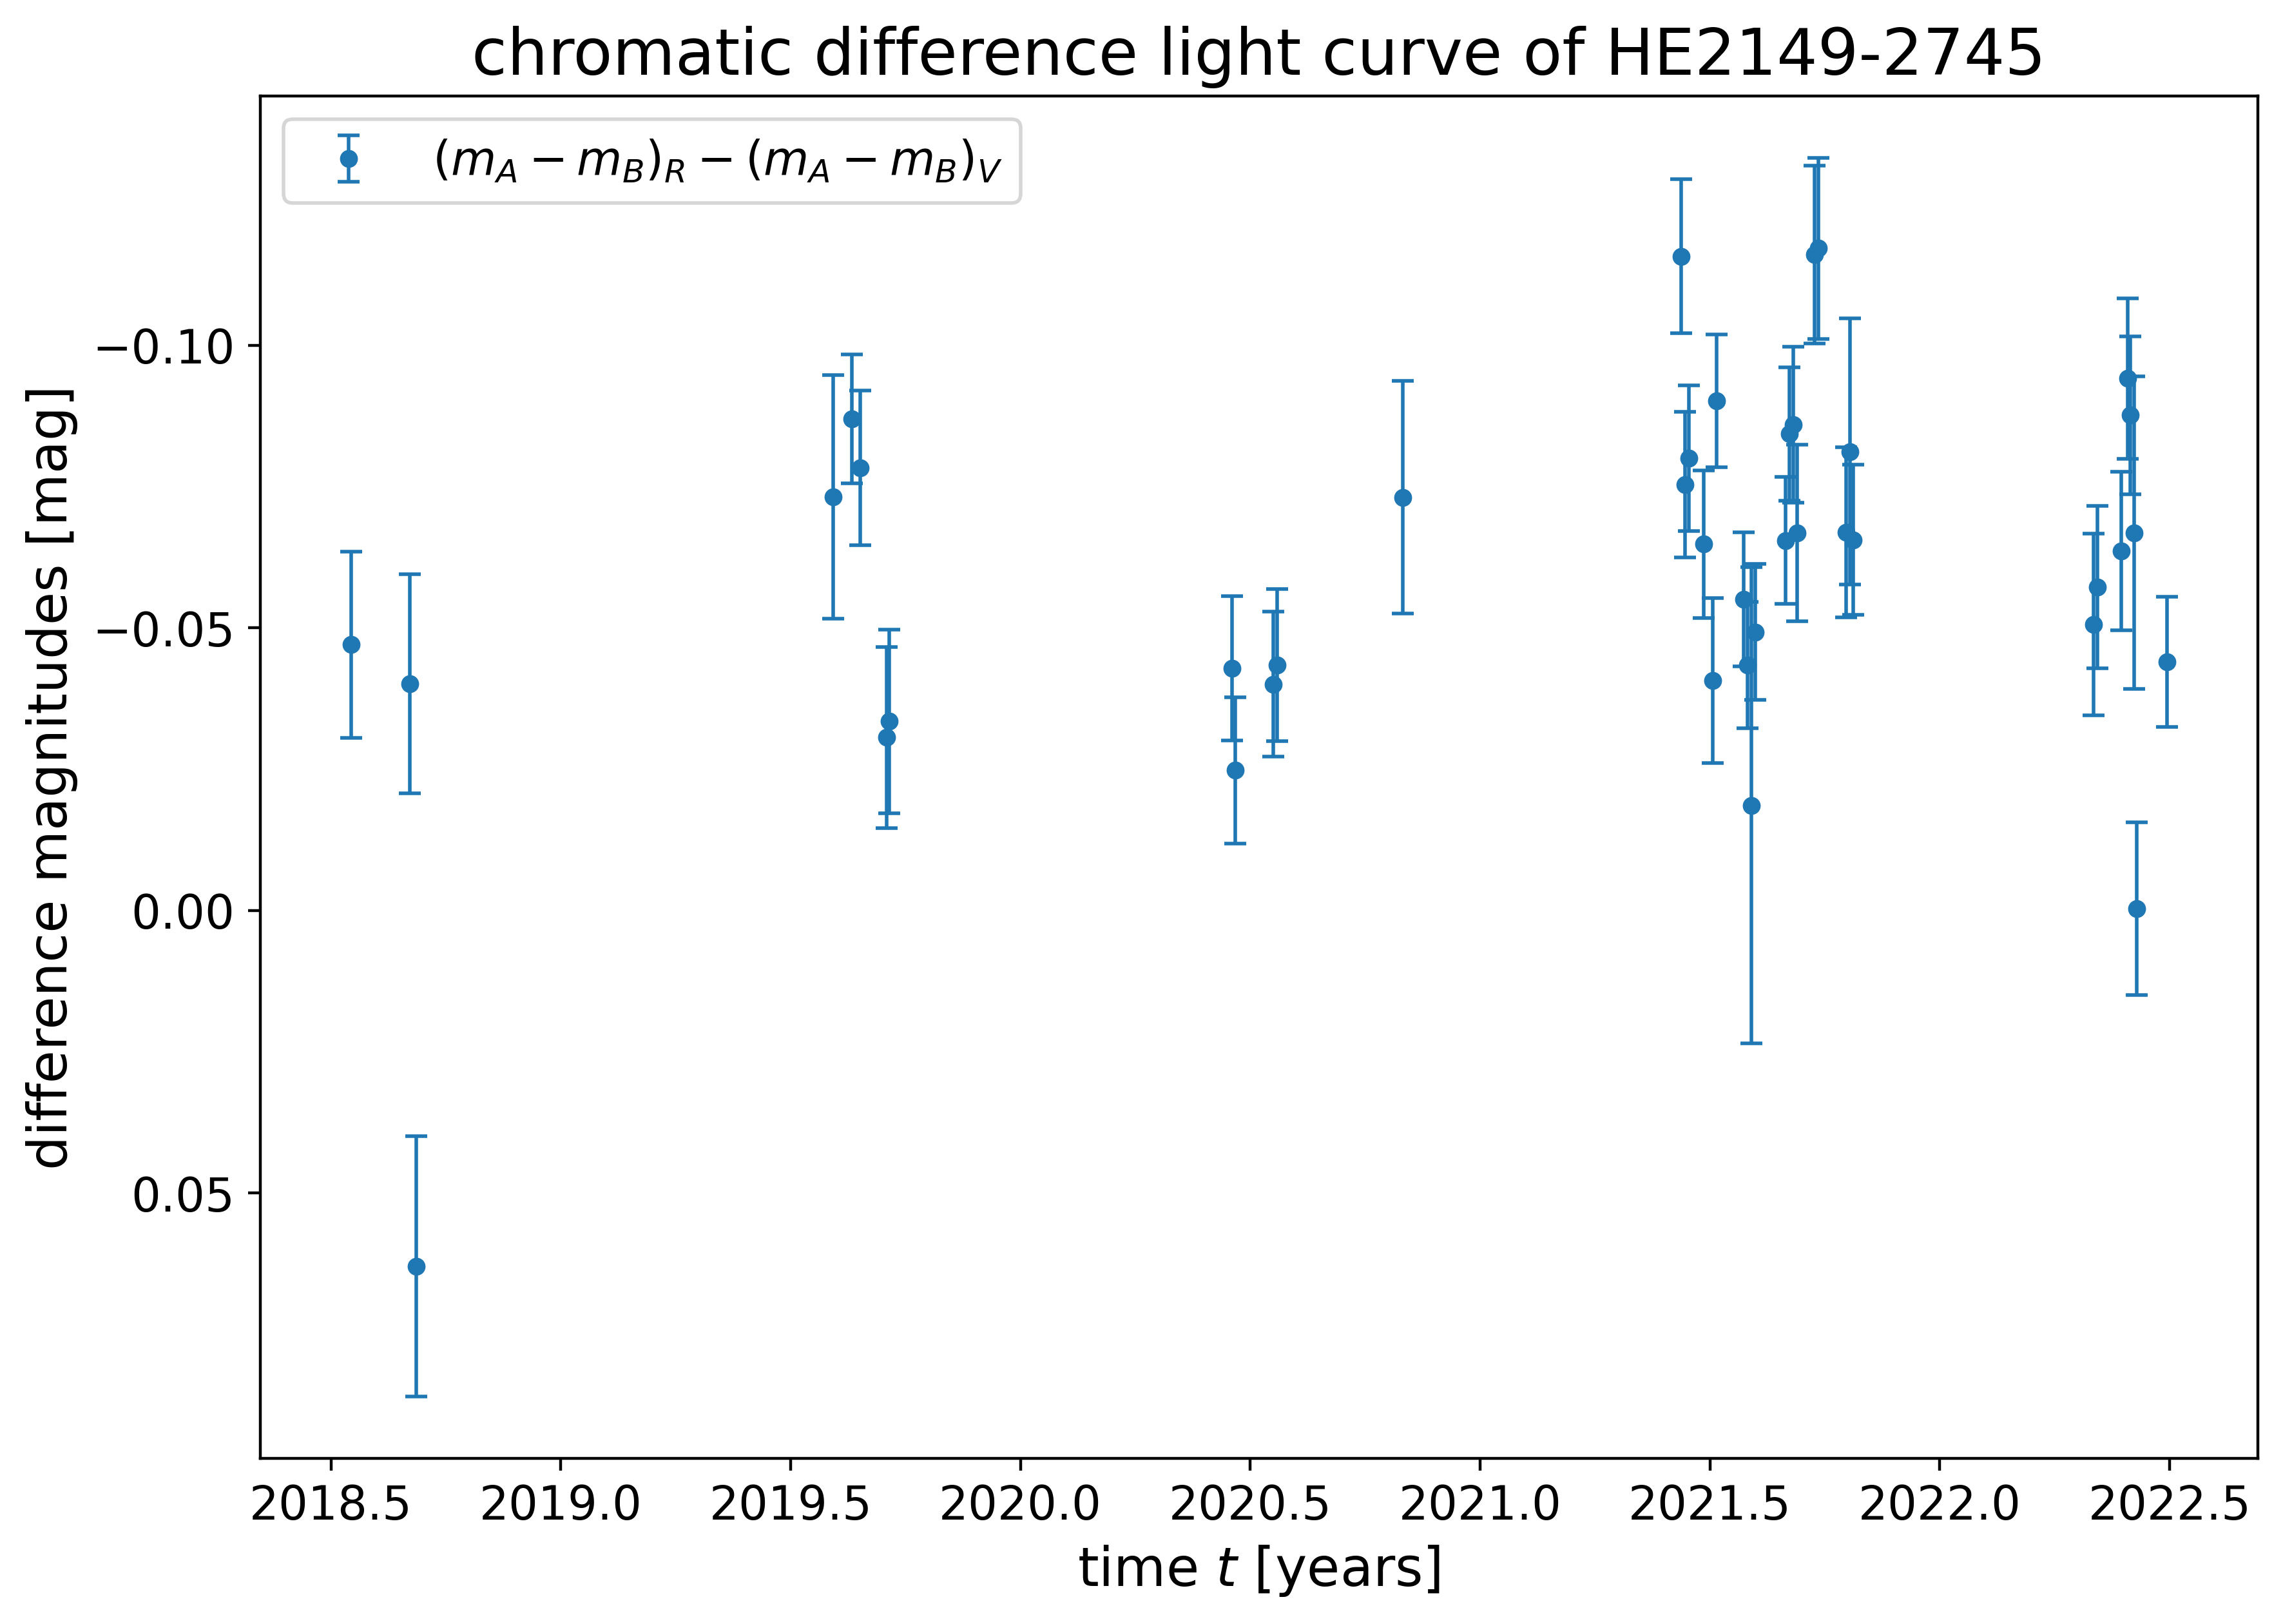

In [47]:
plt.figure(figsize=(10,7),dpi=400)
plt.title('chromatic difference light curve of HE2149-2745',size=18)
plt.errorbar(eq_time,RV_diff,yerr=RV_derr,fmt='o',markersize=4,elinewidth=1,capsize=3,label='$(m_A-m_B)_R-(m_A-m_B)_V$')
plt.gca().invert_yaxis()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('time $t$ [years]',size=15)
plt.ylabel('difference magnitudes [mag]',size=15)
plt.legend(fontsize=13,loc='upper left',ncol=3)